In [1]:
using NPZ
using Interpolations
using Cubature
using PyCall
using LinearAlgebra
using BenchmarkTools
# mpb = pyimport("meep.mpb")
# mp = pyimport("meep")
# @pyimport matplotlib.animation as anim
using PyPlot
using QuadGK
# using FFTW
# using Plots
# pyplot()
include("xray_3dphc.jl")
numpy = pyimport("numpy")

PyObject <module 'numpy' from '/home/elinas/miniconda3/envs/mp/lib/python3.7/site-packages/numpy/__init__.py'>

In [2]:
# data = npzread("phc3d_more_g.npz")
# data= npzread("phc3d_constant_eps.npz")
data = npzread("phc_an_files/phc1d_largek_kpar_tm.npz")

kBZ = data["arr_0"]
Δk = kBZ[2] - kBZ[1]
# krange = -0.75:Δk:0.75
# krange = -0.5:Δk:0.5
krange = range(-0.5, 0.5, length=25)


M1dat = data["arr_1"]
M2dat = data["arr_2"]
# M3dat = data["arr_3"]
ωdat = data["arr_3"]
vgdat = data["arr_4"];

Nb = size(ωdat)[1]
NM = size(M1dat)[4]
Nk = size(ωdat)[2]
# ks = range(-0.75,0.75,length=70)
ks = range(-0.5,0.5,length=70);

In [3]:
ωsplines = Array{Any,1}(undef, Nb)
k0 = Integer((Nk+1)/2) # Nk must be odd

for b in 1:Nb
    # replace zeros with an average so we don't go into a bandgap...
    ωband = ωdat[b,:,:]
#     avg = mean(ωband[ωband.!=0])
#     ωband[ωband.==0] .= avg
#     if ωdat[b,k0,k0,k0] == 0
#         ωband[k0,k0,k0] = 0
#     end
    
    ωitp = interpolate(ωband, BSpline(Quadratic(Flat(OnCell()))));
#     ωitp = interpolate(ωdat[b,:,:,:], BSpline(Linear()));
    ωsitp = scale(ωitp, krange, krange.*8);
    ωsplines[b] = ωsitp
end
Msplines = Array{Any,3}(undef, Nb, NM, 3)
for i in 1:2
    key = string("arr_", i)
    Mdat = data[key]
    for b in 1:Nb
        for nz in 1:NM
            Mitp = interpolate(Mdat[b,:,:,nz], BSpline(Quadratic(Flat(OnCell()))));
            Msitp = scale(Mitp, krange, krange.*8);
            Msplines[b,nz,i] = Msitp
        end
    end
end
ωp = 1e19
ωi = 2e15
ωs = ωp - ωi
g = 3.1e10 #being approximate here
gvec = g * [0,0,1]
θB = asin(g*c/(2*ωp))
# println(θB)

χ = 2e-17 #dmmd
# χ = 1.3e-13 # LN
# χ = 4.7e-14 # GA
np = 1e14
# a = 0.5e-6 #PhC lattice spacing
a = 0.5e-6 # free space lattice spacing.... get more accurate modes??
L = 1e-4 #1mm where period is micron scale sounds reasonable

θdev = 0.001
ϕdev = 0.0025

P = PumpBeam(1e19, θB, 0.0)
D_tm = PhC_Data(a, Msplines, ωsplines, 0);

In [4]:
function kB_func(ω,kp,ϵ1,ϵ2,d1,a,pol="te")
    d2 = a - d1;
    if (ϵ1*ω^2/c^2 - kp^2) >= 0 || ϵ2*ω^2/c^2 - kp^2 >= 0
        kz1 = sqrt(Complex(ϵ1*ω^2/c^2 - kp^2));
        kz2 = sqrt(Complex(ϵ2*ω^2/c^2 - kp^2));
        if pol == "tm"
            p = kz2/kz1;
        else
            p = ϵ1/ϵ2*kz2/kz1;
        end
        x = cos(kz1*d1)*cos(kz2*d2) - (1/2)*(p+1/p)*sin(kz1*d1)*sin(kz2*d2);
        if abs(x) < 1 && imag(x) == 0
            K = acos(x)/a;
            else 
            K = 0#NaN;
        end
    else
        K = 0#NaN
    end
    return K
end


function mode_coeffs_and_norm(ω,kp,ϵ1,ϵ2,d1,a,pol="te")
    k1 = sqrt(Complex(ϵ1*ω^2/c^2 - kp^2));
    k2 = sqrt(Complex(ϵ2*ω^2/c^2 - kp^2));
    if pol == "tm"
        p = k2/k1;
    else
        p = ϵ1/ϵ2*k2/k1;
    end
    kb = kB_func(ω,kp,ϵ1,ϵ2,d1,a,pol);
    d2 = a - d1;
    M = [-exp(-1im*k1*d1) exp(1im*k2*d1) exp(-1im*k2*d1)
    exp(-1im*k1*d1) p*exp(1im*k2*d1) -p*exp(-1im*k2*d1)
    -exp(1im*kb*a) exp(1im*k2*a) exp(-1im*k2*a)]
    V = [exp(1im*k1*d1), exp(1im*k1*d1), exp(1im*kb*a)];
    coeffs = inv(M)*V;
    a1 = 1;
    b1 = coeffs[1];
    a2 = coeffs[2];
    b2 = coeffs[3];
    
    function F12(z)
        F1z = a1*exp(1im*k1*z) + b1*exp(-1im*k1*z)
        F1z2 = ϵ1*abs(F1z)^2;
        return F1z2
    end

    function F22(z)
        F2z = a2*exp(1im*k2*z) + b2*exp(-1im*k2*z)
        F2z2 = ϵ2*abs(F2z)^2;
        return F2z2
    end
    norm = sqrt(quadgk(F12,0,d1)[1] + quadgk(F22,d1,a)[1]);
    
   
    return coeffs, norm
end



mode_coeffs_and_norm (generic function with 2 methods)

In [146]:
function dΓdωdΩ_1D_analytical(ωs::AbstractFloat, θs::AbstractFloat, ϕs::AbstractFloat, gvec, P::PumpBeam, D::PhC_Data, χ::AbstractFloat, np::AbstractFloat, L::AbstractFloat, band::Integer, ϵbg::Real=1; lz::AbstractFloat=0.2e14, pol="te")
    ωp = P.ωp
    θp = P.θp 
    ϕp = P.ϕp
    
    kp = ωp/c
    ks = ωs/c
    
    a = D.a
    ϵ1 = 5.3
    ϵ2 = 1

    kiz = -ks*sin(θs) - kp*sin(θp) + gvec[3]
    kiy = -ks*cos(θs)*sin(ϕs) + kp*cos(θp)*sin(ϕp) + gvec[2]
    kB = - ks*cos(θs)*cos(ϕs) + kp*cos(θp)*cos(ϕp) + gvec[1]
    k0z = kiz * a/(2π)
    k0y = kiy * a/(2π)
    k0x = (kB * a / (2π) + 100.5) % 1 - 0.5 # in MPB units
    
    noffset = -floor(kB*a/(2π) + 0.5) # g
    kpar = sqrt(kiz^2 + kiy^2)
    k0par = kpar *a/(2π)

    
    if abs(k0par) > 4 # we don't have enough data for that
        return 0,0,0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0
    end

    ωspline = D.ωspline[band]
    ω0 = ωspline(k0x, k0par)
    ωi = ω0 * 2π*c / (a*sqrt(ϵbg)) # ϵbg to be used for free space simulations; 1 otherwise
    
    if ϵ1*ωi^2/c^2 - kpar^2 < 0 && ωi^2/c^2 - kpar^2 < 0
        return 0,0,0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0
#         return 0
    end
    
    # do the mode integral analytically
    # but first get the mode coefficients numerically...
    coeffs, norm = mode_coeffs_and_norm(ωi, kpar, ϵ1, ϵ2, a/2, a, pol)
    a1 = 1/norm
    b1 = coeffs[1]/norm
    a2 = coeffs[2]/norm
    b2 = coeffs[3]/norm
    
    
    k1 = sqrt(Complex(ϵ1*ωi^2/c^2 - kpar^2))
    
    Δkzp = gvec[1] + kp*cos(θp)*cos(ϕp) -ks*cos(θs)*cos(ϕs) + k1 #+ noffset * 2π/a
    Δkzm = gvec[3] + kp*cos(θp)*cos(ϕp) -ks*cos(θs)*cos(ϕs) - k1 #+ noffset * 2π/a
    k1 = sqrt(Complex(5.3*ωi^2/c^2 - kpar^2))
    k2 = sqrt(Complex(ωi^2/c^2 - kpar^2))
    
    g = 2π*noffset/a
    
    kb_c = kB_func(ωi,kpar,ϵ1,ϵ2,a/2,a, pol)
    zs = range(0, 31*a/64, length=32)
    M2 = abs(quadgk(z -> efield_fast(z, ωi, kpar, a, 5.3, a1, b1, a2, b2, k1, k2, k0x*2π/a, pol=pol)*exp(2im*π*noffset/a*z), 0, a/2)[1])^2/a
    M2_abs = abs(quadgk(z -> efield_fast(z, ωi, kpar, a, 5.3, a1, b1, a2, b2, k1, k2, abs(k0x*2π/a), pol=pol)*exp(2im*π*noffset/a*z), 0, a/2)[1])^2/a

#     M2 = (abs(sum(efield_fast.(zs, ωi, kpar, a, ϵ1, a1, b1, a2, b2, k1, k1, pol).*exp.(-2im*π*zs*noffset/a)))*a/64)^2/(a)
#     M2 = abs(sum((a1*exp.(1im*(k1+g)*zs) + b1*exp.(-1im*(k1-g)*zs)))*a/64)^2/a
    
    Ep2 = ħ*np*ωp/(2*ϵ0)
    prefactor = ωs^3/(16*π^2*c^3*ϵbg) * Ep2 * L^3 * χ^2 #* a/2
#     polfactor = (1-(kix/sqrt(kpar^2+kB^2)))^2
    if pol == "te"
        polfactor = abs(sum(normalize([kB, kiy, kiz]).*normalize(gvec)))^2
    else
        
        polfactor = 1 - abs(sum(normalize([kB, kiy, kiz]).*normalize(gvec)))^2
    end

    m2_list = [abs(quadgk(z -> efield_fast(z, ωi, kpar, a, 5.3, a1, b1, a2, b2, k1, k2, k0x*2π/a, pol=pol)*exp(2im*π*n/a*z), 0, a/2)[1]) for n in -3:3]/sqrt(a)
    efield_list = [efield_fast(z, ωi, kpar, a, 5.3, a1, b1, a2, b2, k1, k2, k0x*2π/a, pol=pol) for z in range(0, a*511/512, length=512)]
    dΓdωdΩ = prefactor * ωi * M2 * lor(ωp - ωs - ωi, lz) * polfactor 
    return kb_c, M2, k1, Ep2, kB, kpar, a1, b1, noffset, k0x, k0par, dΓdωdΩ, ωi, m2_list, efield_list, lor(ωp - ωs - ωi, lz), M2_abs
#     return dΓdωdΩ
end

dΓdωdΩ_1D_analytical (generic function with 2 methods)

In [6]:
# 0 to a/2 in the unit zone is the dielectric, the rest (a/2-a) is air
# inputs are in physical units, not MPB units
function efield(z, ω, kp, a, ϵ, pol="te", bloch_phase=false)
    coeffs, norm = mode_coeffs_and_norm(ω,kp,ϵ,1,a/2,a,pol)
    a1 = 1/norm
    b1 = coeffs[1]/norm
    a2 = coeffs[2]/norm
    b2 = coeffs[3]/norm
    k1 = sqrt(Complex(ϵ*ω^2/c^2 - kp^2))
    k2 = sqrt(Complex(ω^2/c^2 - kp^2))
    kB_c = kB_func(ω,kp,5.3,1.0,a/2,a,pol)
    if bloch_phase
        if (floor(2*z/a) % 2) == 0
            return a1*exp(1im*k1*z) + b1*exp(-1im*k1*z)
        else
            return a2*exp(1im*k2*z) + b2*exp(-1im*k2*z)
        end
    else
        if (floor(2*z/a) % 2) == 0
            return (a1*exp(1im*k1*z) + b1*exp(-1im*k1*z))*exp(-1im*kB_c*z)
        else
            return (a2*exp(1im*k2*z) + b2*exp(-1im*k2*z))*exp(-1im*kB_c*z)
        end
    end
end

efield (generic function with 3 methods)

In [65]:
function efield_fast(z, ω, kp, a, ϵ, a1, b1, a2, b2, k1, k2, kB_c; pol="te", bloch_phase=false)
    if bloch_phase == true
        if (floor(2*z/a) % 2) == 0
            return a1*exp(1im*k1*z) + b1*exp(-1im*k1*z)
        else
            return a2*exp(1im*k2*z) + b2*exp(-1im*k2*z)
        end
    else
         if (floor(2*z/a) % 2) == 0
            return (a1*exp(1im*k1*z) + b1*exp(-1im*k1*z))*exp(-1im*kB_c*z)
        else
            return (a2*exp(1im*k2*z) + b2*exp(-1im*k2*z))*exp(-1im*kB_c*z)
        end
    end
    
end

efield_fast (generic function with 1 method)

In [8]:
function ft_slow(in_arr)
    n = size(in_arr)[1]
    out_arr = Array{Any,1}(undef, n)
    for k in 1:n
        out_arr[k] = 0
    end
    for m in 1:n
        for k in 1:n
            out_arr[k] += in_arr[m]*exp(-2im*π*(m*k/n))
        end
    end
    return abs.(out_arr)
end

ft_slow (generic function with 1 method)

In [9]:
# k0z = k0xa
# k0p = k0para
k0z = 0.3
k0p = 0.3
kip = k0p*2*π/a
band = 1
ωi = D_tm.ωspline[band](k0z, k0p) * 2π*c / (a)
ωi*ħeV

0.5679954623507916

In [10]:
coeffs, n = mode_coeffs_and_norm(ωi,kip,5.3,1,a/2,a,"tm")
a1 = 1/n
b1 = coeffs[1]/n;
a2 = coeffs[2]/n;
b2 = coeffs[3]/n;

In [11]:
println(coeffs)
println(n)
println("a1: ", a1)
println("b1: ", b1)
println("a2: ", a2)
println("b2: ", b2)

Complex{Float64}[0.08046341575643695 + 0.38068806491776824im, 2.5603534230633813 + 1.274114196871592im, -0.43377201783024705 + 0.15514070234556138im]
0.001584209208738419
a1: 631.2297608699974
b1: 50.79090268671888 + 240.3016361841049im
a2: 1616.1712789829776 + 804.2587998123239im
b2: -273.8098070870831 + 97.92942844279216im


In [12]:
# plot the modes vs. the MPB ones
numz = 512
zs = range(0, a*(numz-1)/(2*numz), length=numz)
Δz = zs[2] - zs[1]
k1 = sqrt(Complex(5.3*ωi^2/c^2 - kip^2))
k2 = sqrt(Complex(ωi^2/c^2 - kip^2))
kBc = kB_func(ωi, kip, 5.3, 1, a/2 , a, "tm")
# E_1 = npzread("phc_an_files/phc1d_modes.npz")["arr_0"]
# E_1b = npzread("phc_an_files/phc1d_modes.npz")["arr_1"]


Δϕf = angle(E_1[1,3,1,1,1]) - angle(efield_fast(zs[1], ωia, kpara, a, 5.3, a1a, b1a, a1a, b1a, k1a, k1a, kB_ca, pol="tm"))

# plot(angle.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm", bloch_phase=false)))
plot(angle.(efield.(zs, ωi, kip, a, 5.3, "tm")))
# plot(abs.(efield.(zs, ωi, kip, a, 5.3,"tm"))*sqrt(a))


plot(angle.(E_1[1,3,1:512,1,1]))


# println(angle(efield(zs[64], ωi, kip, a, 5.3,"tm", true)) - angle(efield(zs[1], ωi, kip, a, 5.3,"tm", true)))
# kB_c = (angle(efield(zs[64], ωi, kip, a, 5.3,"tm", true)) - angle(efield(zs[1], ωi, kip, a, 5.3,"tm", true)))/a

LoadError: UndefVarError: E_1 not defined

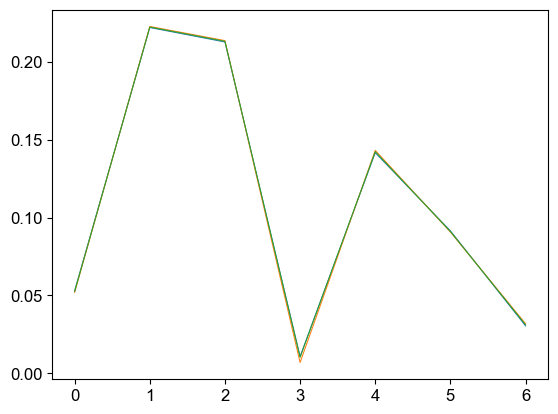

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f07009d3350>

In [55]:
# plot sme M values
band = 2
k1 = sqrt(Complex(5.3*ωi^2/c^2 - kip^2))
k2 = sqrt(Complex(ωi^2/c^2 - kip^2))
ωi = D_tm.ωspline[band](k0z, k0p) * 2π*c / (a)
kBc = kB(ωi,kip,5.3,1.0,a/2,a,"tm")
M_1_z = npzread("phc_an_files/phc1d_M_1_z_kpar-0.3.npz")["arr_0"]

# plot([abs(quadgk(z -> efield(z, ωi, kip, a, 5.3,"tm")*exp(-2im*π*n/a*z), 0, a/2)[1]) for n in -3:3]/sqrt(a))
plot([abs(quadgk(z -> efield_fast(z, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm")*exp(-2im*π*n/a*z), 0, a/2)[1]) for n in -3:3]/sqrt(a))
# plot([abs(sum(E_1[band,2,:,1,1].*exp.(-2im*π*zs*n/a))) for n in -3:3]/(2*numz))
plot([D_tm.Mspline[band,n,2](k0z, k0p) for n in 1:7])
plot(M_1_z)

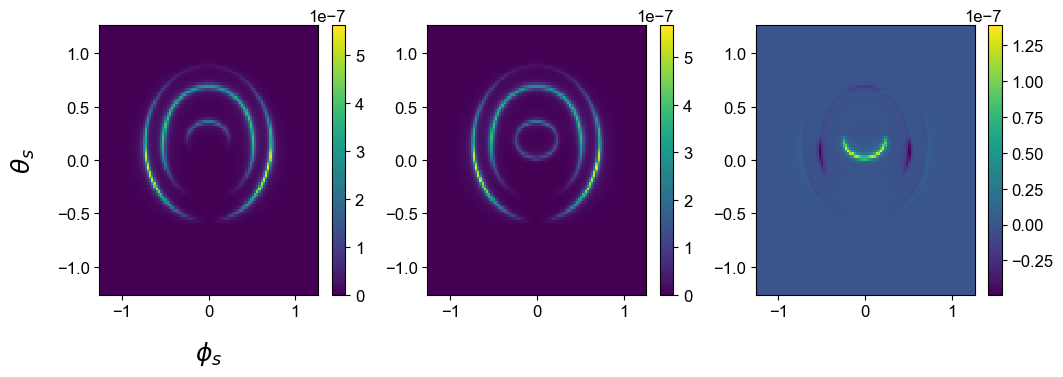

PyObject <matplotlib.colorbar.Colorbar object at 0x7f5b89ddb3d0>

In [148]:
ωi = 2/ħeV #2/ħeV
Nangles = 100
θdev = 0.00125
ϕdev = 0.00125
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]
b = 2
# noffset, k0_vec_no_unit, k_r, M0, ωi, lor
Threads.@threads for b in 1:6
    newdat = [(dΓdωdΩ_1D(ωp - ωi, θs, ϕs, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm"))
#               + dΓdωdΩ_1D(ωp - ωi, θs, ϕs, gvec, P, D_fs_tm, χ, np, L, b, lz=0.6e14, pol="tm")*cos(θs))
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end
subplots(1,3, figsize=(12, 3.5))
subplot(1,3,1)
# ωi, M0^2, lor, kB, k0x, noffset, kivec, polfactor, k0y, kiz, k0par
# dat = [dΓdωdΩ_1D(ωp - ωi, θs, ϕs, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")
#                         for θs in θrange, ϕs in ϕrange]

pcolormesh(ϕrange.*1000, (θrange.-θB).*1000, dat)
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()

subplot(1,3,2)
# what the function returns:
# 1   2   3   4    5     6      7   8     9      10    11    12     13      14     15     16     
# kB, M2, k1, Ep2, kB_c, kpar, a1, b1, noffset, k0x, k0par, dΓdωdΩ, ωi, m2_list, efield, lor
# dat2 = [dΓdωdΩ_1D_analytical(ωp - ωi, θs, ϕs, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[9]
#                             for θs in θrange, ϕs in ϕrange]

dat2 = zeros(Nangles, Nangles)
Threads.@threads for b in 1:6
    newdat = [dΓdωdΩ_1D_analytical(ωp - ωi, θs, ϕs, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[12]
                            for θs in θrange, ϕs in ϕrange]
    global dat2 .+= newdat
end
pcolormesh(ϕrange.*1000, (θrange.-θB).*1000, dat2)
# xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
# ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()


subplot(1,3,3)
pcolormesh(ϕrange.*1000, (θrange.-θB).*1000, dat2 .- dat)
# xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
# ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()

In [84]:
ωi = 3.2/ħeV #2/ħeV
Nangles = 50
θdev = 0.00125
ϕdev = 0.00125
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]
b = 4
ϕ = 0.0
# noffset, k0_vec_no_unit, k_r, M0, ωi, lor
# Threads.@threads for b in 2:2
#     newdat = [(info_1D(ωp - ωi, θs, ϕs, gvec, P, D_tm, χ, np, L, b, 5.3, lz=0.6e14, pol="tm")[2])
# #               + dΓdωdΩ_1D(ωp - ωi, θs, ϕs, gvec, P, D_fs_tm, χ, np, L, b, lz=0.6e14, pol="tm")*cos(θs))
#                         for θs in θrange, ϕs in ϕrange]
#     global dat .+= newdat
# end

# ωi, M0^2, lor, kB, k0x, noffset, kivec, polfactor, k0y, kiz, k0par
info_m = [info_1D(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b)[i]
                        for i in 1:11, θs in θrange]
m2sm = info_m[2, :]
ωim = info_m[1, :]
k0parm = info_m[11, :]
k0xm = [info_1D(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b)[5]
                        for θs in θrange]
noffsetm = [info_1D(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b)[6]
                        for θs in θrange]

kBm = [info_1D(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b)[4]
                        for θs in θrange]

# what the function returns
# 1     2   3   4    5     6      7   8     9      10    11    12     13      14     15    16    17
# kB_c, M2, k1, Ep2, kB, kpar, a1, b1, noffset, k0x, k0par, dΓdωdΩ, ωi, m2_list, efield, lor, M2_abs
info_an = [dΓdωdΩ_1D_analytical(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[i]
                        for i in 1:17, θs in θrange]
m2sa = info_an[2, :]
m2sabs_a = info_an[17, :]
ωisa = info_an[13, :]
kparsa = info_an[6, :]
# m2a = [dΓdωdΩ_1D_analytical(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[2]
#                         for θs in θrange]
noffseta = info_an[9, :]
k0xsa =  info_an[10, :]#[dΓdωdΩ_1D_analytical(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[10]
                        #for θs in θrange]
kba =  info_an[5, :]
kbca =  info_an[1, :];
k0para = info_an[11, :];

In [98]:
ωisa[32]

3.607003103440263e15

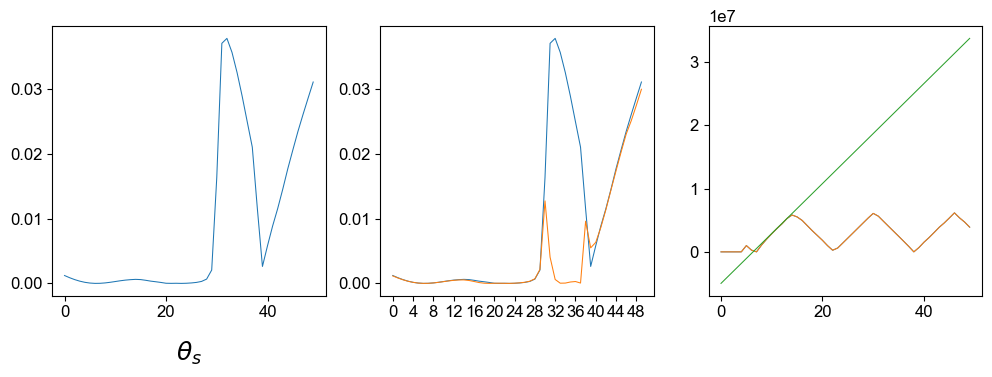

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5b8ac5f550>

In [96]:
subplots(1,3, figsize=(12, 3.5))
subplot(1,3,1)
plot(m2sm)
xlabel(L"$θ_s$", fontsize=18.0, labelpad=14)

subplot(1,3,2)
plot(m2sm)
# plot([kB_func(ωisa[i], kparsa[i], 5.3, 1, a/2, a, "tm") for i in 1:50]/1e8)
plot(m2sa)
# plot((kB_func.(ωisa, kparsa, 5.3, 1, a/2, a, "tm").- abs.(k0xsa*2π/a))*1e-8)
# plot(noffseta)
xticks(0:4:50);

subplot(1,3,3)
plot([kB_func(ωisa[i], kparsa[i], 5.3, 1, a/2, a, "tm") for i in 1:50])
# plot(k0xsa*2π/a)
# plot(k0xm*2π/a)
plot(kbca)
plot(kba)

# plot([kB_func(ωisa[i], kparsa[i], 5.3, 1, a/2, a, "tm") for i in 10:40] .- abs.(k0xsa[10:40]*2π/a))

# plot((m2a .- dat))

## Test $\theta_s$ = 0.483602, $\phi_s$ = 0, b = 4 (i=32)
also checked i=24 for something that matches up

In [144]:
i = 24
θrange[i]
numz = 512
zs = range(0, a*(numz-1)/(numz), length=numz)
println(k0para[i])
println(k0xsa[i])

0.7794688519092736
0.04837891256843818


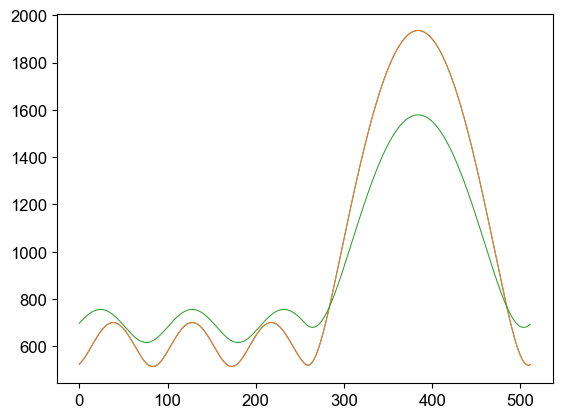

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5b8a290310>

In [145]:
kpar = kparsa[i]
ωia = ωisa[i]
plot(abs.(efield.(zs, ωia, kpar, a, 5.3, "tm", true)))
coeffs, n = mode_coeffs_and_norm(ωia,kpar,5.3,1,a/2,a,"tm")

a1 = 1/n
b1 = coeffs[1]/n;
a2 = coeffs[2]/n;
b2 = coeffs[3]/n;
kb = kba[32]
k1 = sqrt(Complex(5.3*ωia^2/c^2 - kpar^2))
k2 = sqrt(Complex(ωia^2/c^2 - kpar^2))
plot(abs.(efield_fast.(zs, ωia, kpar, a, 5.3, a1, b1, a2, b2, k1, k2,  k0xsa[i]*2π/a, pol="tm", bloch_phase=true)))

E_1 = npzread("phc_an_files/phc1d_modes_k0x-0.779468_k0par-0.048378_b-4_tm.npz")["arr_0"]
E_1b = npzread("phc_an_files/phc1d_modes_k0x-0.779468_k0par-0.048378_b-4_tm.npz")["arr_1"]
Δϕf = angle(E_1b[4,3,1,1,1]) - angle(efield_fast(zs[1], ωia, kpar, a, 5.3, a1, b1, a1, b1, k1, k1, k0xsa[i]*2π/a, pol="tm"))

plot(abs.(E_1b[4,3,1:512,1,1])/sqrt(a)) #.- Δϕf)


# M2 = abs(quadgk(z -> efield_fast(z, ωi, kpar, a, 5.3, a1, b1, a2, b2, k1, k2, k0xsa[32]*2π/a, pol=pol)*exp(2im*π*noffset/a*z), 0, a/2)[1])^2/a

In [128]:
size(E_1)

(6, 3, 512, 1, 1)

In [110]:
println(kB_func(ωia,kparsa[32],5.3,1,a/2,a,"tm"))
println(kba[32])
println(kbca[32])
println(kB_func(ωia, kpar, 5.3, 1, a/2, a, "tm"))
println(k0xsa[32]*2π/a)
# println(kp)

5.64441887445601e6 - 0.0im
1.9499309649036407e7
5.64441887445601e6 - 0.0im
5.64441887445601e6 - 0.0im
-5.633431579682e6


In [283]:
#why are there places where there are no modes according to kb_func but there are according to MPB?
info_m = [info_1D(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[i]
                        for i in 1:11, θs in θrange]
ωim, M2m, lorm, kBm, k0xm, noffsetm, kivecm, polfactorm, k0ym, kizm, k0parm = info_m[:, 32]
# kBa, M2a, k1a, Ep2a, kB_ca, kpara, a1a, b1a, noffseta, k0xa, k0para, dΓdωdΩa, ωia, m2_lista, efielda, lora = info_an[:, 31]
# println(kB_ca)
println("kb func: ", kB_func(ωia, kpara, 5.3, 1, a/2, a,"tm"))
println("kpara: ", kpara)
println("k0parm: ", k0parm)
println(kBm)
println(ωim)
println("ωi mpb: ", ωim*a/(2π*c))

kb func: 5.684192067766578e6 - 0.0im
kpara: 2.253942379081726e6
k0parm: 0.17936303553758165
1.9499309649036407e7
9.175804895876875e14
ωi mpb: 0.24356465583231351


k0xa: -0.196484068642107 k0xm: -0.4482942412381874
k0para: 0.6587019194706539 k0parm: 0.17936303553758165
-2.0


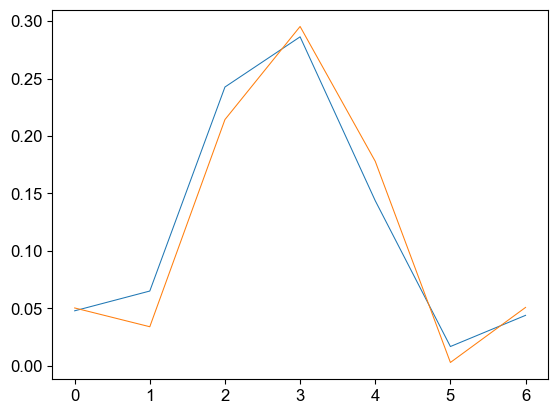

0.0028466755654479856
0.02324257575088054


In [285]:
# compare M2 values at an inconsistent point
i = 37
info_an = [dΓdωdΩ_1D_analytical(ωp - ωi, θs, ϕ, gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm")[i]
                        for i in 1:17, θs in θrange]
kBa, M2a, k1a, Ep2a, kB_ca, kpara, a1a, b1a, noffseta, k0xa, k0para, dΓdωdΩa, ωia, m2_lista, efielda, lora, M2_abs = info_an[:, i]
# you can plug these values into MPB to get the modes
println("k0xa: ", k0xa)
println("k0para: ", k0para)
println(noffseta)
# plot([abs(quadgk(z -> efield_fast(z, ωia, kpara, a, 5.3, a1a, b1a, a1a, b1a, k1a, k1a, k0xa*2π/a, pol="tm")*exp(-2im*π*n/a*z), 0, a/2)[1]) for n in -3:3]/sqrt(a))
plot(m2_lista)
plot([D_tm.Mspline[b,n,2](k0xa, k0para) for n in 7:-1:1])
# plot(dΓdωdΩ_1D_analytical(ωp - ωi, θrange[17], 0., gvec, P, D_tm, χ, np, L, b, lz=0.6e14, pol="tm"))


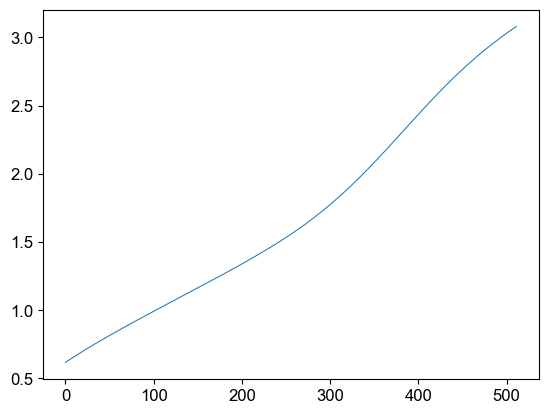

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f341ba46190>

In [289]:
plot(angle.(efielda))

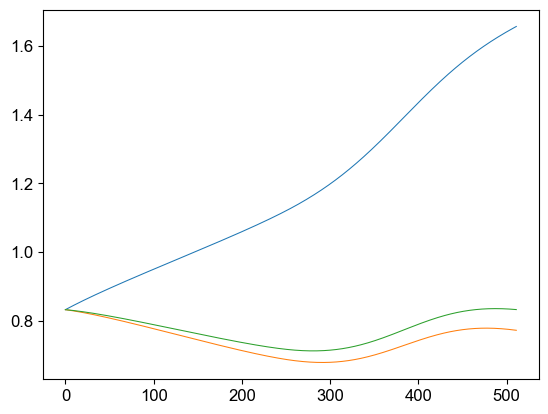

765643.4676025783 - 0.0im
-886460.6802144292


In [290]:
# plot the modes with different bloch vectors
coeffs, n = mode_coeffs_and_norm(ωia,kpara,5.3,1,a/2,a,"tm")
a1 = 1/n
b1 = coeffs[1]/n;
a2 = coeffs[2]/n;
b2 = coeffs[3]/n;
kb_c = kB_func(ωia, kpara, 5.3, 1, a/2, a,"tm")
k2 = sqrt(Complex(ωia^2/c^2 - kpara^2))
plot(angle.(efield_fast.(zs, ωia, kpara, a, 5.3, a1, b1, a2, b2, k1a, k2, k0xa*2π/a, pol="tm", bloch_phase=false)))
plot(angle.(efield_fast.(zs, ωia, kpara, a, 5.3, a1, b1, a2, b2, k1a, k2, -(k0xa*2π/a), pol="tm", bloch_phase=false)))
plot(angle.(efield_fast.(zs, ωia, kpara, a, 5.3, a1, b1, a2, b2, k1a, k2, kb_c, pol="tm", bloch_phase=false)))

# plot(angle.(efield.(zs, ωia, kpara, a, 5.3, "tm",false)))
# plot(angle.(efielda))
println(kb_c)
println(k0xa*2π/a)

In [259]:
# check if the mode is periodic by checking the angle at the boundaries
angle(efield_fast(zs[1], ωia, kpara, a, 5.3, a1, b1, a2, b2, k1a, k2, kb_c, pol="tm", bloch_phase=false)) - angle(efield_fast(zs[512], ωia, kpara, a, 5.3, a1, b1, a2, b2, k1a, k2, kb_c, pol="tm", bloch_phase=false))

-0.00023143991205698544

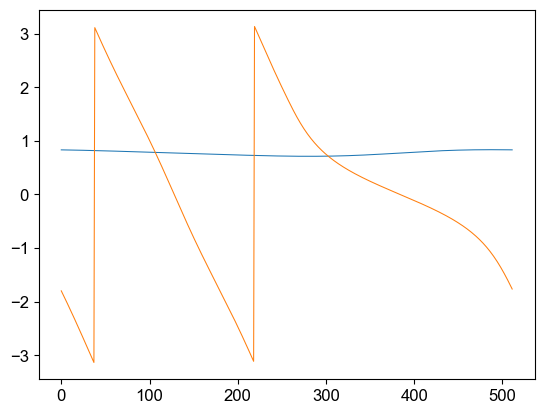

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f34194b38d0>

In [287]:
numz = 512
zs = range(0, a*(numz-1)/(numz), length=numz)
Δz = zs[2] - zs[1]
E_1 = npzread("phc_an_files/phc1d_modes_k0x--0.19648_k0par-0.65870_b-4_tm.npz")["arr_0"]
# E_1b = npzread("phc_an_files/phc1d_modes_kpar-0.299_k0x--0.385_tm.npz")["arr_1"]
# E_1 = npzread("phc_an_files/phc1d_modes_kpar-0.3_tm.npz")["arr_0"]


# Δϕf = angle(E_1[band,3,1,1,1]) - angle(efield_fast(zs[1], ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm"))
Δϕf = -angle(E_1[4,3,1,1,1]) - angle(efield_fast(zs[1], ωia, kpara, a, 5.3, a1a, b1a, a1a, b1a, k1a, k1a, k0xa*2π/a, pol="tm"))

# plot(angle.(efield_fast.(zs, ωia, kpara, a, 5.3, a1a, b1a, a1a, b1a, k1a, k1a, k0xa*2π/a, pol="tm", bloch_phase=false)))
# plot(angle.(efielda.*exp(1im*Δϕf)))
plot(angle.(efield.(zs, ωia, kpara, a, 5.3, "tm", false)))

# plot(abs.(efielda))# plot(real.(efield_fast.(zs, ωia, kpara, a, 5.3, a1a, b1a, a1a, b1a, k1a, k1a, kB_ca, pol="tm", bloch_phase=false))*sqrt(a))

# plot(abs.(efield.(zs, ωi, kip, a, 5.3,"tm"))*sqrt(a))


plot(-angle.(E_1[4,3,1:512,1,1]))

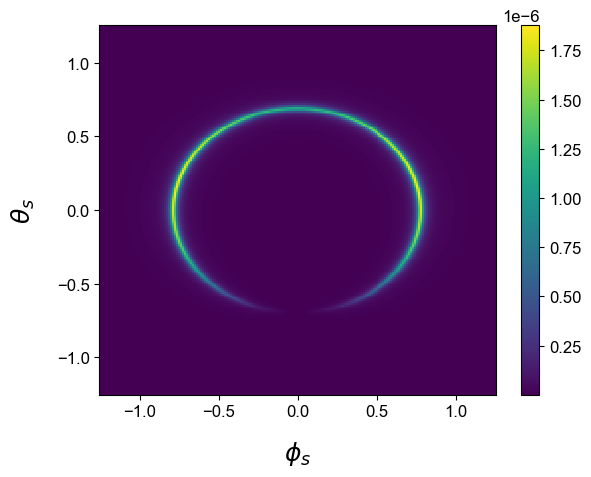

PyObject <matplotlib.colorbar.Colorbar object at 0x7f81d2803bd0>

In [151]:
ωi = 2.2/ħeV #2/ħeV
Nangles = 200
θdev = 0.00125
ϕdev = 0.00125
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor
Threads.@threads for b in 1:1
    newdat = [dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 5.3, χ, np, L, lz=0.6e14, pol="tm")
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end

pcolormesh(ϕrange.*1000, (θrange.-θB).*1000, dat)
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()

## Things on top of each other
stacks on stacks on stacks

### Bands
note how there are no bands found by the kb function!

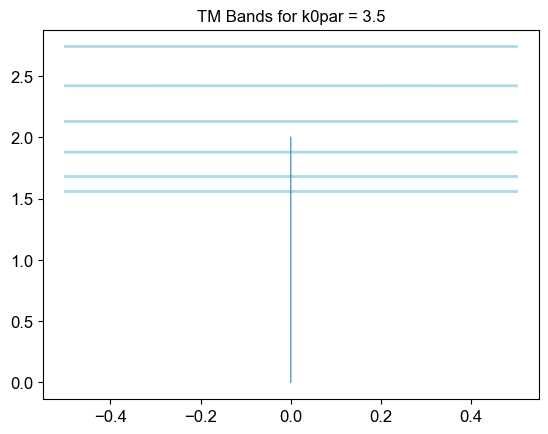

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f34348bc350>

In [8]:
for b in 1:6
    plot(ks, D_tm.ωspline[b](ks, 3.5), color="lightblue", linewidth=2)
end
ωirange = range(0, 2.0* 2π*c / (a), length=10000)
kip = 3.5*2π/a
kBs = kB_func.(ωirange, kip, 5.3, 1, a/2 , a, "tm")
title("TM Bands for k0par = 3.5")
plot(kBs*a/(2π), ωirange.*a/(2π*c))

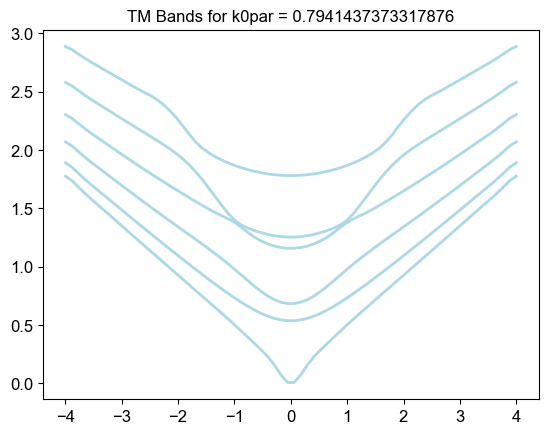

PyObject Text(0.5, 1.0, 'TM Bands for k0par = 0.7941437373317876')

In [264]:
for b in 1:6
    plot(ks.*8, D_tm.ωspline[b](0, ks.*8), color="lightblue", linewidth=2)
end
ωirange = range(0, 2.0* 2π*c / (a), length=1000)
kip = k0parm*2π/a
kBs = kB_func.(ωirange, kip, 5.3, 1, a/2 , a, "tm")
title("TM Bands for k0par = $(k0parm)")
# plot(kBs*a/(2π), ωirange.*a/(2π*c))

In [255]:
#index
println(ωim*a/(2π*c)/2*1000)
println(ωim*a/(2π*c))

205.2815982612497
0.41056319652249945


In [256]:
D_tm.ωspline[b](k0xm, k0parm)

0.4105631965224994

In [257]:
k0xm

-0.03644058019695251

In [254]:
ωirange[208]*a/(2π*c)

0.4144144144144144

In [252]:
kBs[208]*a/(2π)

0.13767606256523254 - 0.0im

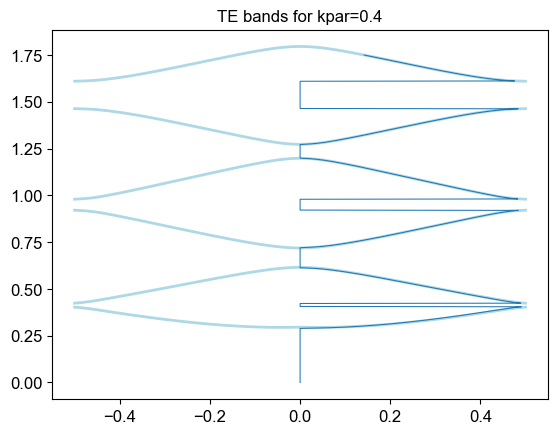

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f069a3e0210>

In [115]:
for b in 1:6
    plot(ks, D_te.ωspline[b](ks, 0.4), color="lightblue", linewidth=2)
end
ωirange = range(0, 1.75* 2π*c / (a), length=1000)
kip = 0.4*2π/a
kBs = kB_func.(ωirange, kip, 5.3, 1, a/2 , a, "te")
title("TE bands for kpar=0.4")
plot(kBs*a/(2π), ωirange.*a/(2π*c))

### Modes

### Modes

In [208]:
numz = 1024
zs = range(0, a*(numz-1)/numz, length=numz)
Δz = zs[2] - zs[1];

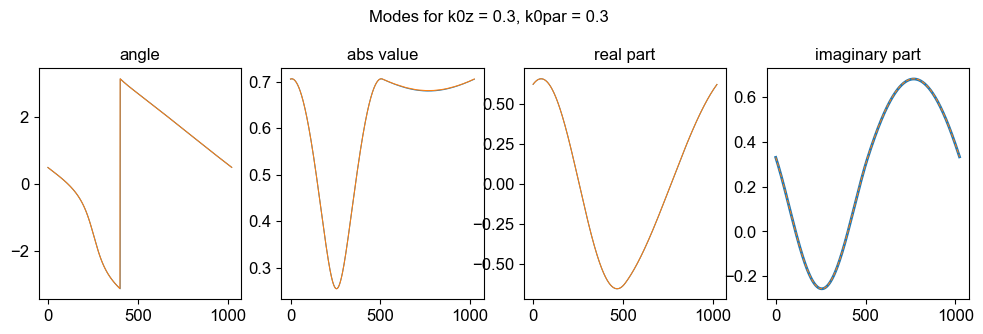

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f06998dfe10>

In [118]:
k0z = 0.3
k0p = 0.3
kip = k0p*2*π/a
band = 2
ωi = D_tm.ωspline[band](k0z, k0p) * 2π*c / (a)
coeffs, n = mode_coeffs_and_norm(ωi,kip,5.3,1,a/2,a,"tm")
a1 = 1/n
b1 = coeffs[1]/n;
a2 = coeffs[2]/n;
b2 = coeffs[3]/n;

k1 = sqrt(Complex(5.3*ωi^2/c^2 - kip^2))
k2 = sqrt(Complex(ωi^2/c^2 - kip^2))
kBc = kB_func(ωi, kip, 5.3, 1, a/2 , a, "tm")
E_1 = npzread("phc_an_files/phc1d_modes_kpar-0.3.npz")["arr_0"]

Δϕf = angle(E_1[band,3,1,1,1]) - angle(efield_fast(zs[1], ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm"))

subplots(1,4, figsize=(12,3))
suptitle("Modes for k0z = 0.3, k0par = 0.3", y=1.0745)
subplot(1,4,1)
title("angle")
plot(angle.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm").*exp(1im*Δϕf)))
plot(angle.(E_1[band,3,:,1,1]))
subplot(1,4,2)
title("abs value")
plot(abs.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm").*exp(1im*Δϕf))*sqrt(a))
plot(abs.(E_1[band,3,:,1,1]))
subplot(1,4,3)
title("real part")
plot(real.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm").*exp(1im*Δϕf))*sqrt(a))
plot(real.(E_1[band,3,:,1,1]))
subplot(1,4,4)
title("imaginary part")
plot(imag.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm").*exp(1im*Δϕf))*sqrt(a), linewidth=2)
plot(imag.(E_1[band,3,:,1,1]), linestyle="dashed")



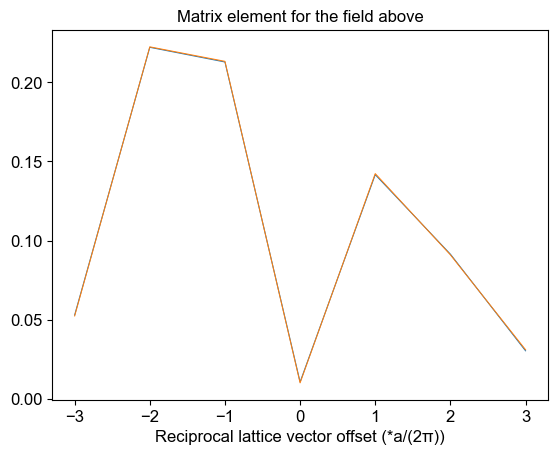

PyObject Text(0.5, 25.078125, 'Reciprocal lattice vector offset (*a/(2π))')

In [236]:
M_1_z = npzread("phc_an_files/phc1d_M_1_z_kpar-0.3.npz")["arr_0"]

plot(range(-3, 3, length=7), [abs(quadgk(z -> efield_fast(z, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="te")*exp(-2im*π*n/a*z), 0, a/2)[1]) for n in -3:3]/sqrt(a))
plot(range(-3, 3, length=7), M_1_z)
title("Matrix element for the field above")
xlabel("Reciprocal lattice vector offset (*a/(2π))")

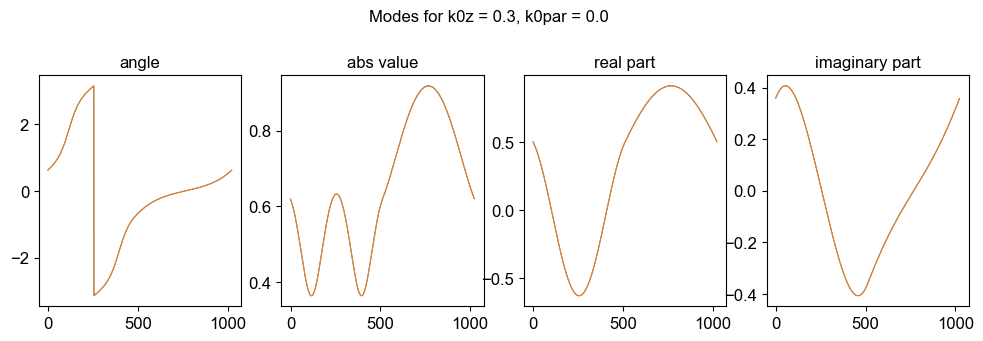

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe2ba4ac4d0>

In [237]:
k0z = 0.3
k0p = 0.0
kip = k0p*2*π/a
band = 3
ωi = D_tm.ωspline[band](k0z, k0p) * 2π*c / (a)
coeffs, n = mode_coeffs_and_norm(ωi,kip,5.3,1,a/2,a,"tm")
a1 = 1/n
b1 = coeffs[1]/n;
a2 = coeffs[2]/n;
b2 = coeffs[3]/n;
k1 = sqrt(Complex(5.3*ωi^2/c^2 - kip^2))
k2 = sqrt(Complex(ωi^2/c^2 - kip^2))
kBc = kB_func(ωi, kip, 5.3, 1, a/2 , a, "tm")
E_1 = npzread("phc_an_files/phc1d_modes.npz")["arr_0"]
Δϕf = angle(E_1[band,2,1,1,1]) - angle(efield_fast(zs[1], ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm"))

subplots(1,4, figsize=(12,3))
suptitle("Modes for k0z = 0.3, k0par = 0.0", y=1.1)
subplot(1,4,1)
title("angle")
plot(angle.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm").*exp(1im*Δϕf)))
plot(angle.(E_1[band,2,:,1,1]))
subplot(1,4,2)
title("abs value")
plot(abs.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm").*exp(1im*Δϕf))*sqrt(a))
plot(abs.(E_1[band,2,:,1,1]))
subplot(1,4,3)
title("real part")
plot(real.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm").*exp(1im*Δϕf))*sqrt(a))
plot(real.(E_1[band,2,:,1,1]))
subplot(1,4,4)
title("imaginary part")
plot(imag.(efield_fast.(zs, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="tm").*exp(1im*Δϕf))*sqrt(a))
plot(imag.(E_1[band,2,:,1,1]))

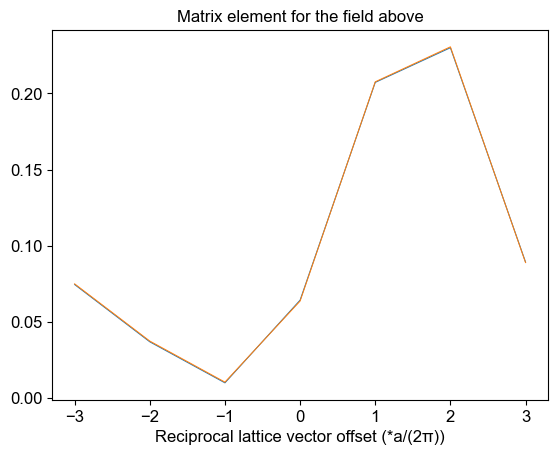

PyObject Text(0.5, 25.078125, 'Reciprocal lattice vector offset (*a/(2π))')

In [239]:
M_1_y = npzread("phc_an_files/phc1d_M_1_y.npz")["arr_0"]
plot(range(-3, 3, length=7), [abs(quadgk(z -> efield_fast(z, ωi, kip, a, 5.3, a1, b1, a2, b2, k1, k2, kBc, pol="te")*exp(-2im*π*n/a*z), 0, a/2)[1]) for n in -3:3]/sqrt(a))
plot(range(-3, 3, length=7), M_1_y)
title("Matrix element for the field above")
xlabel("Reciprocal lattice vector offset (*a/(2π))")

### Mode integrals